# Principles of a bootstrap aggregation of stable clusters
This tutorial illustrates the basic principles behind the "Bootstrap Aggregation of Stable Clusters (BASC)" algorithm for fMRI time series, using simulations and real data. 

  * **Time for completion**: this tutorial will take 5-10 minutes to complete. 
  * **Dependencies**: the [data-science jupyter docker stack](https://github.com/jupyter/docker-stacks/tree/master/datascience-notebook). The main dependencies are sklearn, joblib, nilearn, scipy, numpy and matplotlib.

In [18]:
%matplotlib inline
import sklearn.cluster as cl
import sklearn.metrics as mt
import sklearn.utils as ut
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import nilearn as nl

/home/pbellec/env/jupyter_ds/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Simple simulations: mixture of Gaussians
## Simulate time series with a known cluster structure
Let's start with a function which simulates time series. The following function deals with the simulation of the time series, and uses a mixture model of Gaussians. The simulations just consist of random gaussian noise. We add a single (random) single signal to all regions within a cluster. All clusters are set to have the same size. The function also supports multiresolution clusters, but we will get at that latter.

In [3]:
def simu_tseries(n_time,n_roi,n_clusters,alpha) :
    y = np.random.normal(size=[n_roi , n_time])
    gt = np.zeros(shape=[n_roi,n_clusters.size])
    
    for ss in range(0,n_clusters.size) :
        ind = np.linspace(0,n_roi,n_clusters[ss]+1,dtype="int")
        for cc in range(0, n_clusters[ss]) :
            cluster = range(ind[cc],ind[cc+1])
            sig = np.random.normal(size=[1,n_time])
            y[cluster,:] = y[cluster,:] + alpha * np.repeat(sig,ind[cc+1]-ind[cc],0)
            gt[cluster,ss] = cc
    return y , gt

The simulation uses the following parameters: a small number of time points (300), a small number of regions (150) and 5 clusters of equal size (that would be 30 regions per cluster). The `alpha` parameter is set high for now, so we can clearly see the clusters.

In [5]:
n_time = 100 # number of time samples
n_roi = 150 # number of regions
n_clusters = np.array([5]) # number  of clusters 
alpha = 0.7 # this parameter controls the homogeneity of each cluster
y , gt = simu_tseries(n_time , n_roi , n_clusters , alpha )

The array Let's visualize the matrix of correlation coefficients between time series, across all pairs of regions.

(150, 100)

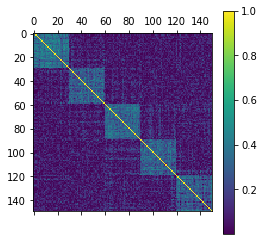

In [8]:
R = sp.corrcoef(y)
plt.matshow(np.abs(R))
plt.colorbar()
y.shape

Note that `y` is a numpy array with 150 rows (regions) and 100 columns (time points). We can see clear diagonal squares. For pairs of regions within a square (cluster), the correlation is about 0.5. By contrast, off-diagonal coefficients have close to zero correlations. The five squares are the five clusters of interest. But in case we have too much noise to see them clearly, the "ground truth" of the true cluster structure used in the simulation is saved in the vector `gt`:

(150, 1)

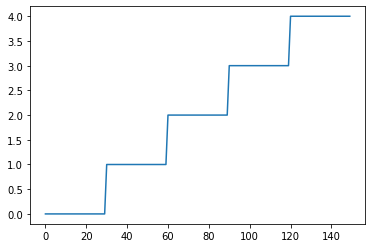

In [9]:
plt.plot(gt)
gt.shape

`gt` is a vector where each entry is a region, and the value associated with a region is an integer value coding for the number of the cluster (starting from 0, and following an arbitrary order).

## k-means clustering
Let's try to recover the clusters with a simple k-means clustering. We'll use k-means as a black box here. It takes `y` as an input, and tries to guess `gt`. We need to specify the number of clusters though, but here we know exactly what it is (`n_cluster = 5`), and we're not going to try to guess it. Note that k-means is one of the oldest, standard clustering algorithms, and you can learn more on its inner workings by following this [tutorial](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html).

In [14]:
cent , part , inert  = cl.k_means(y,n_clusters=5,init="random",max_iter=30)

The output `part` is the estimation of `gt` through the k-means algorithm. Let's see what it looks like.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa55a6a41d0>,
 Text(0.5, 1.0, 'gt'))

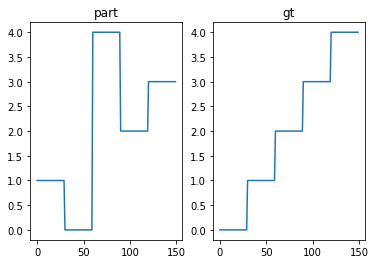

In [31]:
plt.subplot(1,2,1), plt.plot(part), plt.title('part')
plt.subplot(1,2,2), plt.plot(gt), plt.title('gt')

This is looking good! Perfect, in fact. Except the number associated with each cluster appears to be random. But it doesn't matter, because these cluster labels are arbitrary anyway. How can we quantify how good `part` is, without getting mixed up by the cluster labels? 

# A detour: adjacency matrix and adjusted Rand
For measuring the similarity of two cluster solutions, it is useful to represent the clusters as **adjacency matrices**. This representation is also key for the particular BASC flavor we are going to implement, so it's worth taking this little detour. The following function takes a cluster like `gt` and builds a matrix region x region. If two regions are in the same cluster, the value in the matrix is 1. Otherwise it is zero. That's called the adjacency matrix representation of the clustering. 

In [141]:
def part2adj(part):
    part = np.reshape(part,[part.shape[0],1])
    adj = np.repeat(part,part.shape[0],1) == np.repeat(part.transpose(),part.shape[0],0)
    return adj.astype(int)

Now let's look at the two adjacency matrices side by side (estimated vs ground truth): 

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa5590a6c18>,
 Text(0.5, 1.0, 'gt'))

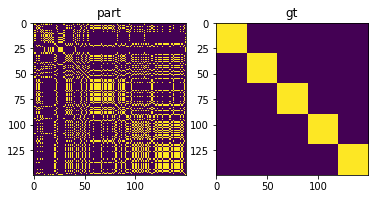

In [152]:
part_adj = part2adj(part)
plt.subplot(1,2,1), plt.imshow(part_adj), plt.title('part')
gt_adj = part2adj(gt)
plt.subplot(1,2,2), plt.imshow(gt_adj), plt.title('gt')

So we can see those two representations are identical. If we were to count the proportion of elements in the two matrices that are identical (excluding the diagonal which is always 1), we would get a measure of agreement called the Rand index. And here Rand would be 1, because all coefficients are the same (and the two cluster solutions are thus identical). But even if we selected 5 clusters randomly with equal size, we would get a Rand that is substantially higher than 0, because we would have lots of blue coefficients in our adjacency matrices, and those would necessarily overlap. The **adjusted Rand** score corrects for this chance-level overlap, such that the adjusted Rand will be close to zero for cluster overlap near chance level, and adjusted Rand is 1 for identical cluster solutions. Let's apply this measure here:

In [153]:
perf = mt.adjusted_rand_score(part,gt[:,0])
print("adjusted rand score:",perf)

adjusted rand score: 0.15183509841993822


Note that scikit-learn actually does not need the adjacency matrix representation, but works directly from vectors of cluster labels. Now that we are familiar with the adjusted Rand index, let's run another simulation with less homogeneity whithin clusters, to see if k-means fairs as well as before. 

In [164]:
y , gt = simu_tseries(n_time=100, n_roi=150 , n_clusters=np.array([5]) , alpha=0.3 )
cent , part , inert  = cl.k_means(y,n_clusters=5,init="random",max_iter=30)

Let's visualize again the adjacency matrices and compute the performance of k-means:

adjusted rand score: 0.39224581694522553


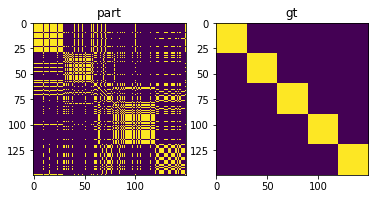

In [155]:
part_adj = part2adj(part)
plt.subplot(1,2,1), plt.imshow(part_adj), plt.title('part')
gt_adj = part2adj(gt)
plt.subplot(1,2,2), plt.imshow(gt_adj), plt.title('gt')
perf = mt.adjusted_rand_score(part,gt[:,0])
print("adjusted rand score:",perf)

So we have definitely found a scenario where k-means struggles. But this is just one simulation. Let's repeat the experiment a bunch of times and see how the performance replicates.

Mean performance (adjusted Rand):  0.29560743110131804


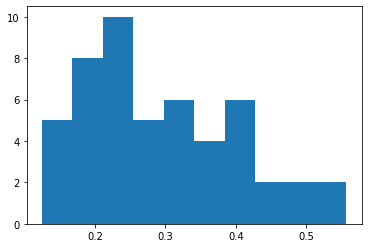

In [42]:
n_simu = 50
perf = np.zeros(n_simu)
for ss in range(0,n_simu) :
    y, gt = simu_tseries(n_time , n_roi , n_clusters , alpha)
    cent, part, inert  = cl.k_means(y, n_clusters=5, init="random", max_iter=30)
    perf[ss] = mt.adjusted_rand_score(part, gt[:,0])
plt.hist(perf)
print("Mean performance (adjusted Rand): ",perf.mean())

So let's see now if we can improve the performance of k-means through bootstrap aggregation (bagging).

## Bagging
We are now going to try out the evidence accumulation algorithm described by [Fred and Jain (2005)](https://www.ncbi.nlm.nih.gov/pubmed/15943417). The algorithm is as follows:
 * replicate the original time series multiple times, using bootstrap. 
 * for each replicated time series, replicate k-means. 
 * Represent each cluster solution as an adjacency matrix, and average them. This generates a "stability" or "co-occurence" matrix. 
 * Feed the stability matrix into a clustering procedure as a feature matrix. This cluster solution is an aggregate of all replications, and maybe it works better, because averaging is magic.
 
 We are going to break down this relatively complex procedure into a series of simple code. Let's start by bootstrapping time series:

In [135]:
def bootstrap_tseries(tseries): 
    ind = np.floor(tseries.shape[1] * np.random.rand(tseries.shape[1]))
    tseries_r = np.array([tseries[ii, ind.astype('int')] for ii in range(0, tseries.shape[0])])
    return tseries_r

Let's unpack this quickly. In the first line we are selecting random time points, **with replacement**. This means we sample integers between `0` and `n_time`, and that a given integer can be selected multiple times. This is the simplest form of the bootstrap, and there are better variants for time series, but we'll stick with that for this tutorial. On line 2, the same random time samples, are extracted for each region and pasted into a replication array. Let's try it out on simple time series.

In [140]:
tseries = np.array([[ii for ii in range(0,10)], [ii for ii in range(10,20)]])
tseries_r = bootstrap_tseries(tseries)
print("Original time series:\n",tseries, "\nBootstrap replication:\n", tseries_r)

Original time series:
 [[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]] 
Bootstrap replication:
 [[ 3  0  5  3  4  5  0  3  9  1]
 [13 10 15 13 14 15 10 13 19 11]]


As we can see, the two set of time series have the exact same size. Some time points are present multiple times (and not necessarily adjacent to one another), but the exact same time samples are picked for each region, so to respect spatial correlations present in the data. 

We are now ready to build a function that does the replication, apply k-means, and average the resulting adjancency matrix to give us a stability matrix.

In [165]:
def tseries2stab(tseries, n_clusters, n_samp=30, init="random", max_iter=30):
    for ss in range(0,n_samp):
        tseries_r = bootstrap_tseries(tseries)
        cent, part, inert  = cl.k_means(tseries_r, n_clusters=n_clusters, init=init, max_iter=max_iter)
        stab = part2adj(part) if (ss==0) else part2adj(part) + stab
    stab = stab / n_samp
    return stab

That's really the core of the bagging. Let's run a quick simulation, and compare the spatial correlation matrix with the stability matrix.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa558f666a0>,
 Text(0.5, 1.0, 'stability'))

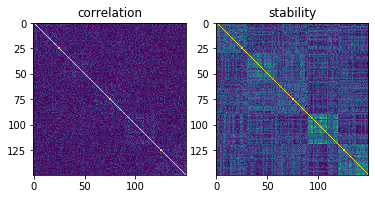

In [167]:
y , gt = simu_tseries(n_time=100, n_roi=150 , n_clusters=np.array([5]) , alpha=0.3 )
stab = tseries2stab(y, n_clusters=5)
R = sp.corrcoef(y)

plt.subplot(1,2,1), plt.imshow(np.abs(R)), plt.title('correlation')
plt.subplot(1,2,2), plt.imshow(stab), plt.title('stability')

With the correlation matrix, which is closely related to the metric used by k-means to find clusters, it is really hard to see any structure. By contrast, the squares are relatively easy to pick with the stability matrix. So hopefully if we use that as a clustering metric, we can get better clusters!

## Consensus clustering
So here comes the last step of the BASC. We are going to apply a clustering procedure on `stab`. Let's define a small function which puts all the pieces together.

In [174]:
def basc(tseries, n_clusters, n_samp=30, init="random", max_iter=30):
    stab = tseries2stab(tseries, n_clusters, n_samp, init, max_iter)
    cent, cons, inert = cl.k_means(stab, n_clusters=n_clusters, init=init, max_iter=max_iter)
    return cons

We can try it out on a simple simulation:

In [176]:
y , gt = simu_tseries(n_time=100, n_roi=150 , n_clusters=np.array([5]) , alpha=0.3 )
cons  = basc(y, n_clusters=5)

We can visualize the consensus adjacency matrix against the ground truth, and get a measure of performance:

adjusted rand score: 0.47424455182346936


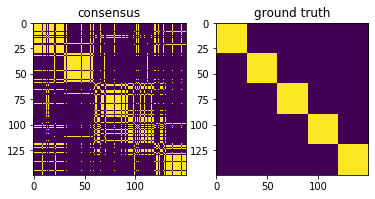

In [178]:
cons_adj = part2adj(cons)
plt.subplot(1,2,1), plt.imshow(cons_adj), plt.title('consensus')
gt_adj = part2adj(gt)
plt.subplot(1,2,2), plt.imshow(gt_adj), plt.title('ground truth')
perf = mt.adjusted_rand_score(cons, gt[:,0])
print("adjusted rand score:", perf)

Not great, but better than what straight k-means gave us (unless you were not lucky with your random sample, which is possible). Let's run a bunch of replications of this experiment to get a better idea of the improvement.

Mean performance (adjusted Rand):  0.4933668287131161


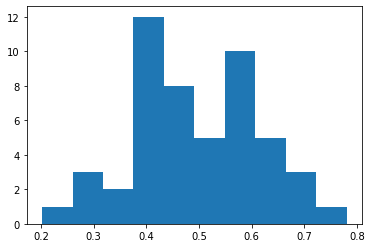

In [179]:
n_simu = 50
perf = np.zeros(n_simu)
for ss in range(0,n_simu) :
    y , gt = simu_tseries(n_time=100, n_roi=150 , n_clusters=np.array([5]) , alpha=0.3 )
    cons = basc(y, n_clusters=5)
    perf[ss] = mt.adjusted_rand_score(cons, gt[:,0])
plt.hist(perf)
print("Mean performance (adjusted Rand): ",perf.mean())

An improvement of 0.2 in adjusted Rand index, not too shabby! Now we could get this type of results by using a more complex algorithm, such as k-means++ initialization. But we could BASC the kmeans++, and still get improvements. We can even mix different algorithms in the bagging, and get some hybrid algorithm. That's actually what Fred and Jain originally proposed, the consensus clustering idea was already present in [Monti et al. (2003)]() and possibly earlier work as well. 